In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from scipy.stats.distributions import norm
from scipy.optimize import fmin, minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
# from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

In [2]:
dfd = pd.read_csv('../Data/salesdaily.csv')
dfd['datum']= pd.to_datetime(dfd['datum'])
dfd["day_number"] = pd.DatetimeIndex(dfd['datum']).day
dfd['Month'] = pd.DatetimeIndex(dfd['datum']).month
dfd['Year'] = pd.DatetimeIndex(dfd['datum']).year
display(dfd)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
0,2014-01-02,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday,2
1,2014-01-03,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday,3
2,2014-01-04,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday,4
3,2014-01-05,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday,5
4,2014-01-06,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2019-10-04,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday,4
2102,2019-10-05,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday,5
2103,2019-10-06,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday,6
2104,2019-10-07,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday,7


In [3]:
#Check for empty strings 
empty = np.array([(dfd[col].astype(str).unique() == '').any() for col in dfd.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

#Check for any missing data
print('\nAny missing data (by column):')
display(dfd.isnull().any())

Any empty strings: False

Any missing data (by column):


datum           False
M01AB           False
M01AE           False
N02BA           False
N02BE           False
N05B            False
N05C            False
R03             False
R06             False
Year            False
Month           False
Hour            False
Weekday Name    False
day_number      False
dtype: bool

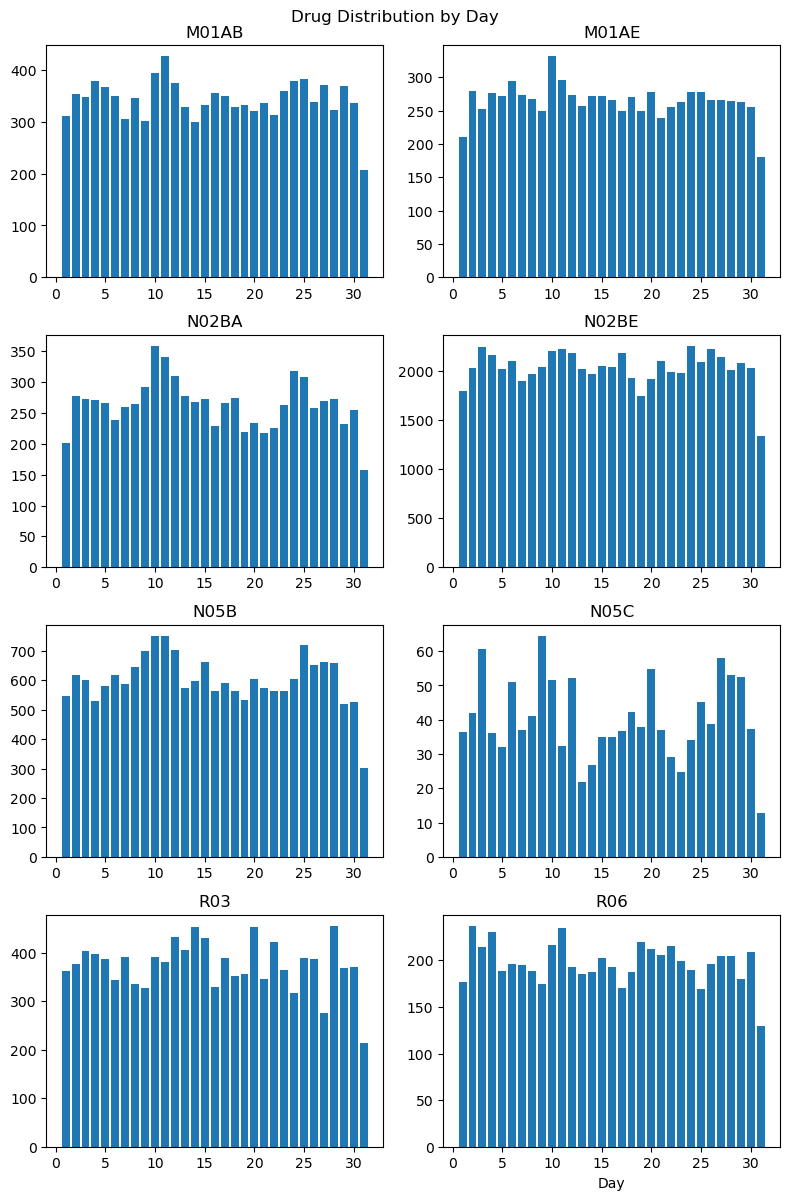

In [4]:
#View drug sales by year

# Group drug sales by week
drug_list = dfd.columns.tolist()[1:9]
gb_year = dfd.groupby(by=['day_number']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot
fig.tight_layout()
fig.suptitle('Drug Distribution by Day')
fig.subplots_adjust(top=0.95)
plt.xlabel('Day')
plt.show()

In [18]:
# creating training, validation, and test datasets
train, test = train_test_split(dfd, test_size=.1, shuffle=False)
display(train)
display(test)
print(dfd.shape)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
0,2014-01-02,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday,2
1,2014-01-03,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday,3
2,2014-01-04,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday,4
3,2014-01-05,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday,5
4,2014-01-06,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2019-03-07,7.33,2.076,4.25,10.00,24.0,0.0,0.0,4.0,2019,3,276,Thursday,7
1891,2019-03-08,2.33,3.340,0.20,33.70,4.0,1.0,0.0,4.3,2019,3,276,Friday,8
1892,2019-03-09,6.34,1.670,4.00,45.20,11.0,0.0,7.0,5.0,2019,3,276,Saturday,9
1893,2019-03-10,5.83,3.087,5.35,51.00,5.0,0.0,3.0,9.0,2019,3,276,Sunday,10


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
1895,2019-03-12,4.33,3.373,1.50,31.85,12.0,0.0,7.0,2.00,2019,3,276,Tuesday,12
1896,2019-03-13,2.67,4.340,6.00,22.00,10.0,0.0,8.0,4.00,2019,3,276,Wednesday,13
1897,2019-03-14,4.00,5.670,0.20,47.20,12.0,1.0,27.0,6.00,2019,3,276,Thursday,14
1898,2019-03-15,2.83,1.340,3.00,40.00,7.0,1.0,20.0,5.00,2019,3,276,Friday,15
1899,2019-03-16,8.34,0.837,5.00,29.00,9.0,0.0,5.0,7.00,2019,3,276,Saturday,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2019-10-04,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday,4
2102,2019-10-05,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday,5
2103,2019-10-06,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday,6
2104,2019-10-07,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday,7


(2106, 14)


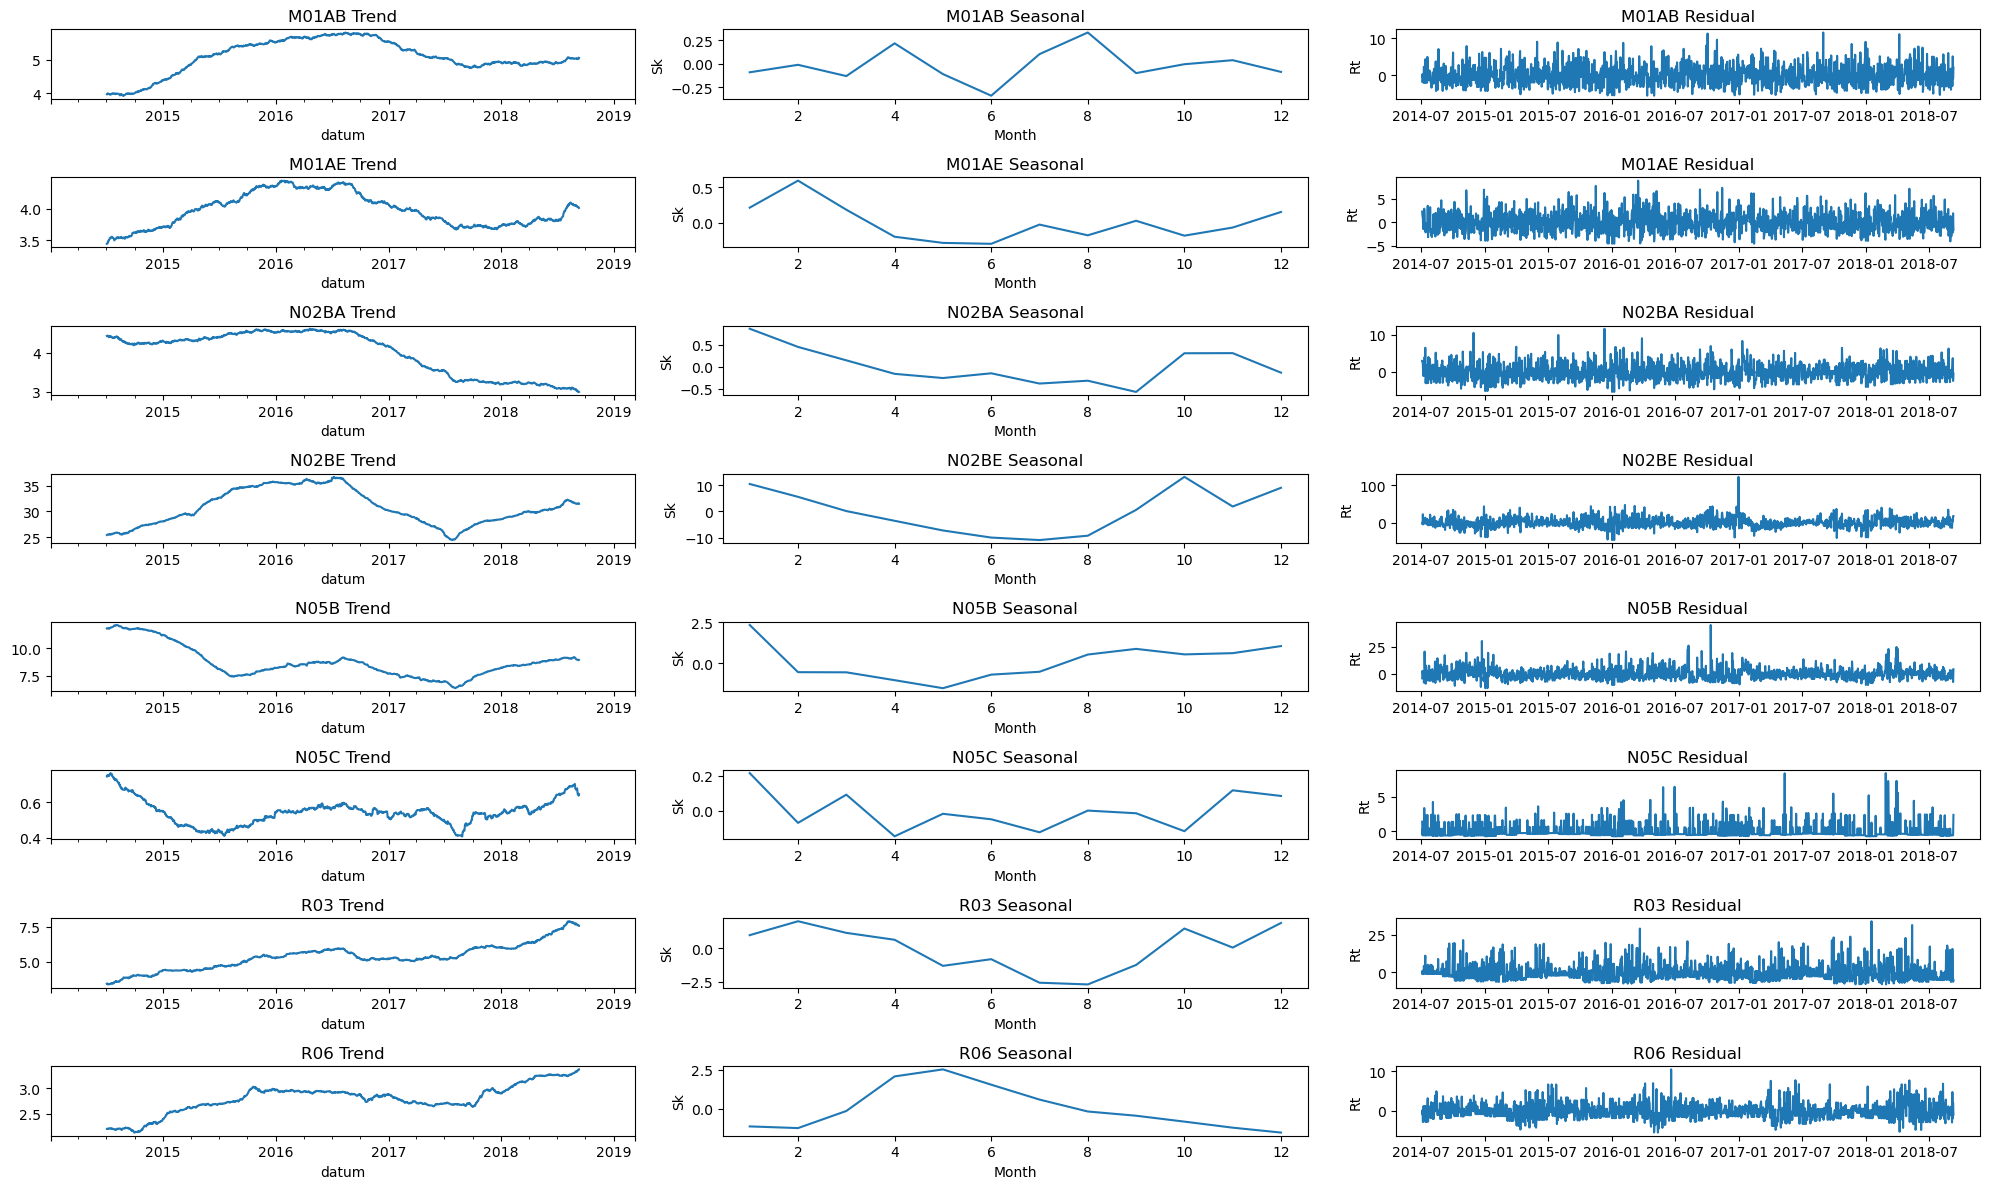

In [6]:
fig = plt.figure(figsize=(20,12))
i=1

for col in drug_list:
  #Get drug's time series
  ts = train.set_index('datum')[col]
  
  #Plot the trend
  tlen = 365
  Tt = ts.rolling(window=tlen, center=True).mean()
  plt.subplot(8,3,i)
  Tt.plot()
  plt.title(f'{col} Trend')
  
  #Detrend the series
  yt = ts[tlen//2:(-tlen//2)+1] - Tt[tlen//2:(-tlen//2)+1]
  
  #Find Sk
  Sk = yt.groupby(yt.index.month).mean()

  #Plot sk
  i += 1
  plt.subplot(8,3,i)
  Sk.plot()
  plt.xlabel('Month')
  plt.ylabel('Sk')
  plt.title(f'{col} Seasonal')

  #Compute residuals
  new = yt.reset_index()
  new['Rt'] = new.apply(lambda row: row[col] - Sk[row['datum'].month], axis=1)
  Rt = new.set_index('datum')['Rt']
  if col == 'N02BA':
    rt_N02BA = Rt

  #Plot
  i += 1
  plt.subplot(8,3,i)
  plt.plot(Rt)
  plt.ylabel('Rt')
  plt.title(f'{col} Residual')
  i += 1
plt.tight_layout()
plt.show()

datum
2014-07-03    2.953660
2014-07-04    2.949550
2014-07-05    1.945166
2014-07-06   -1.046614
2014-07-07   -0.030176
                ...   
2018-09-06    0.561678
2018-09-07    1.572089
2018-09-08    3.672637
2018-09-09   -2.431062
2018-09-10   -0.422569
Name: Rt, Length: 1531, dtype: float64


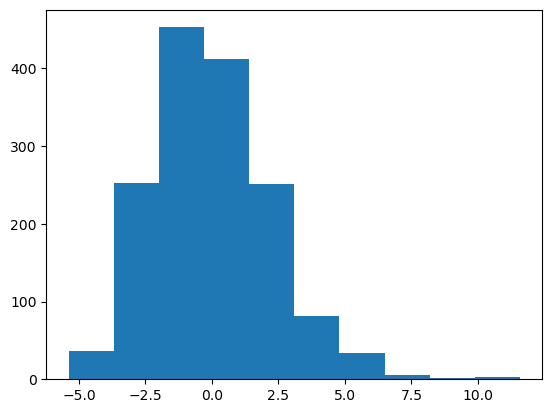

In [7]:
#Get the weekly residuals
print(rt_N02BA)
plt.hist(rt_N02BA)
plt.show()
print()

In [8]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
                              np.eye(dim_states**2).dot(Q.flatten())).reshape(
                            (dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        #FIXME
        t1 = np.linalg.solve(H.dot(covs[i-1]).dot(H.T),np.eye(H.shape[0]))
        t2 = covs[i-1].dot(H.T.dot(t1.dot(H.dot(covs[i-1]))))
        covs[i] = F.dot((covs[i-1] - t2).dot(F.T)) + Q
        mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
                time_series[i-1] - H.dot(mus[i-1]))
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0][:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

In [9]:
def arma_likelihood(ts, phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # Load time series
    time_series = ts
    time_series = np.diff(a=time_series, n=1)

    # Get F, Q, and H
    F, Q, H, _, _ = state_space_rep(phis, thetas, mu, std)

    # Call Kalman
    mus, covs = kalman(F, Q, H, time_series-mu)

    # Compute log liklihood
    log_liklihood = np.sum([np.log(norm(H@mus[t] + mu, np.sqrt(H@covs[t]@H.T)).pdf(time_series[t])) for t in range(len(mus))])
    return log_liklihood
    
# arma_likelihood(train['N02BA'], phis=np.array([0.9]),thetas=np.array([0]), mu=17., std=0.4)

In [ ]:
def model_identification(ts,p_max=4,q_max=4, ours=False):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    if ours:
        # Load time series
        time_series = ts
        # time_series = np.diff(a=time_series, n=1)
        n = len(time_series)
        
        # Make aicc function and initialize best params
        aic_func = lambda k, n, l: 2*k*(1 + (k+1)/(n-k)) + 2*l
        best_params, best_p, best_q, best_aic = 0, 0, 0, np.inf
        
        # Perform the grid search
        for p in range(1, p_max+1):
            print(p)
            for q in range(1, q_max+1):
                print(f"   {q}")
                x0 = np.zeros(p+q+2)+10e-6
                x0[-2] = time_series.mean()
                x0[-1] = time_series.std()
                
                def f(x): # x contains the phis, thetas, mu, and sigma
                    return -1*arma_likelihood(ts, phis=x[:p], thetas=x[p:p+q],mu=x[-2], std=x[-1])

                # Minimize
                sol = minimize(f,  x0, method = "SLSQP").x

                # Compute curr aic
                curr_aic = aic_func(p+q+2, n, f(sol))

                if curr_aic < best_aic:
                    # Update the best params
                    best_params, best_p, best_q = sol, p, q, 
                    best_aic = curr_aic
        return best_params[:best_p], best_params[best_p:best_p+best_q], best_params[-2], best_params[-1]
    else:
        # Load time series
        time_series = ts
        n = len(time_series)
        best_aic = np.inf
        
        # Perform the grid search
        for p in range(1, p_max+1):
            for q in range(1, q_max+1):
                print(f"{p},{q}")
                # Create ARIMA model
                model = ARIMA(time_series,order=(p,0,q),trend='c').fit(method='innovations_mle')

                # Compute curr aicc
                curr_aic = model.aic

                if curr_aic < best_aic:
                    # Update the best model and AIC
                    best_model, best_aic = model, curr_aic
                    best_p, best_q = p, q

        x0 = np.zeros(best_p+best_q+2)+10e-6
        x0[-2] = time_series.mean()
        x0[-1] = time_series.std()
        
        def f(x): # x contains the phis, thetas, mu, and sigma
            return -1*arma_likelihood(ts, phis=x[:best_p], thetas=x[best_p:best_p+best_q],mu=x[-2], std=x[-1])

        # Minimize
        best_params = minimize(f,  x0, method = "SLSQP").x
        return best_params[:best_p], best_params[best_p:best_p+best_q], best_params[-2], best_params[-1]

model_identification(train, p_max=4, q_max=4, ours=False)

In [15]:
display(rt_N02BA)

datum
2014-07-03    2.953660
2014-07-04    2.949550
2014-07-05    1.945166
2014-07-06   -1.046614
2014-07-07   -0.030176
                ...   
2018-09-06    0.561678
2018-09-07    1.572089
2018-09-08    3.672637
2018-09-09   -2.431062
2018-09-10   -0.422569
Name: Rt, Length: 1531, dtype: float64

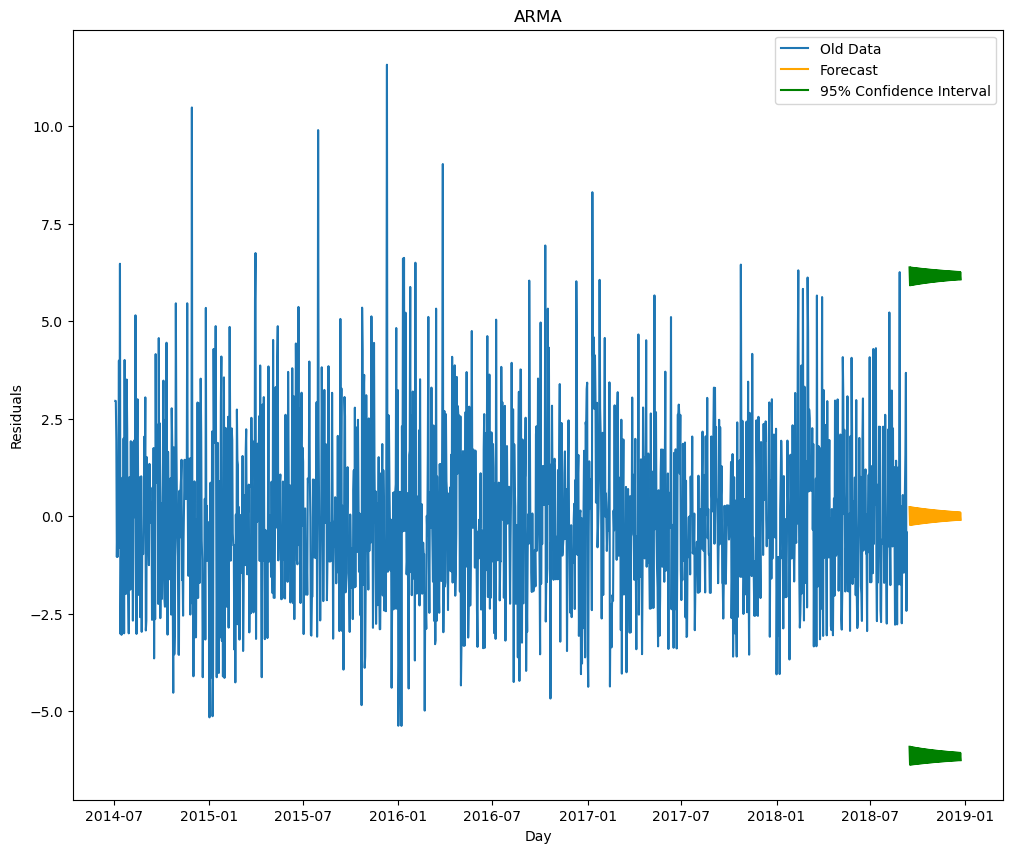

In [11]:
def arma_forecast(ts, phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load time series
    data = ts
    # data = np.diff(a=time_series, n=1)

    # Get F, Q, and H
    F, Q, H, _, _ = state_space_rep(phis, thetas, mu, std)

    # Call Kalman
    mus, covs = kalman(F, Q, H, data-mu)

    # Execute update algorithm
    ytild = data[-1] - H@mus[-1]
    sk = H@covs[-1]@H.T
    kk = covs[-1]@H.T@np.linalg.inv(sk)
    xhat = mus[-1] + kk@ytild
    pk = (np.eye(kk.shape[0]) - kk@H)@covs[-1]

    # Transform back to obs space
    updated_mus, updated_covs = np.zeros(n+1), np.zeros(n+1)
    updated_mus[0], updated_covs[0] = H@mus[-1] + mu, H@covs[-1]@H.T

    xhats, pks = [xhat], [pk]
    for t in range(n):
        # Execute predict algorithm
        xhats.append(F@xhats[t] + mu)
        pks.append(F@pks[t]@F.T + Q)

        # Transform back to obs space
        updated_mus[t+1] = H@xhats[t] + mu
        updated_covs[t+1] = H@pks[t]@H.T

    # Plot
    dates = pd.date_range(data.index.values[-1], periods=n)
    plt.figure(figsize=(12,10))
    plt.plot(data, label='Old Data')
    plt.plot(dates[5:], updated_mus[6:], c='orange', label='Forecast')
    plt.plot(dates[5:], updated_mus[6:] + 2*np.sqrt(updated_covs[6:]), 'g', label='95% Confidence Interval')
    plt.plot(dates[5:], updated_mus[6:] - 2*np.sqrt(updated_covs[6:]), 'g')
    plt.xlabel('Day')
    plt.ylabel('Residuals')
    plt.title('ARMA')
    plt.legend()
    plt.show()
    return dates, updated_mus, updated_covs
    
phis, thetas, mu, std = np.array([-0.96460019,  0.02606689]), np.array([ 4.83738998e-07, -1.00000182e+00]), 1.3701930097295663e-05, 2.2090445822823312
dates, updated_mus, updated_covs = arma_forecast(rt_N02BA, phis=phis, thetas=thetas, mu=mu, std=std, n=105)


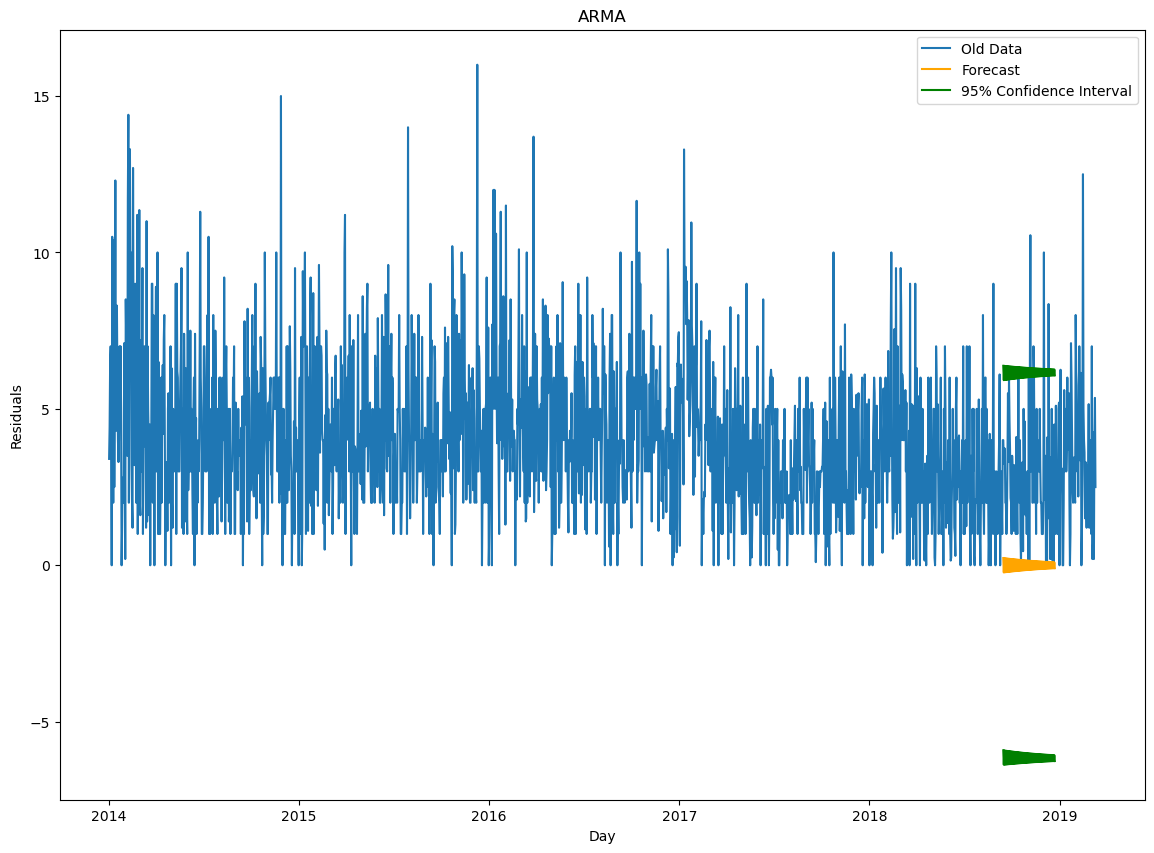

In [13]:
# Plot
# dates = pd.date_range(train.index.values[-1], periods=105)
plt.figure(figsize=(14,10))
plt.plot(dfd['datum'][:1895], dfd['N02BA'][:1895], label='Old Data')
plt.plot(dates[5:], updated_mus[6:], c='orange', label='Forecast')
plt.plot(dates[5:], updated_mus[6:] + 2*np.sqrt(updated_covs[6:]), 'g', label='95% Confidence Interval')
plt.plot(dates[5:], updated_mus[6:] - 2*np.sqrt(updated_covs[6:]), 'g')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.title('ARMA')
plt.legend()
plt.show()